In [1]:
# Install TensorFlow and TensorFlow Hub
!pip install tensorflow tensorflow-hub tensorflow-text

  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached tensorflow_text-2.19.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached numpy-2.1.3-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
  Using cached tf_keras-2.19.0-py3-none-any.whl.metadata (1.8 kB)
Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl (30 kB)
Using cached tensorflow_text-2.19.0-cp312-cp312-macosx_11_0_arm64.whl (6.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 MB 53.7 MB/s eta 0:00:0000:0100:01
Using cached numpy-2.1.3-cp312-cp312-macosx_14_0_arm64.whl (5.1 MB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
Using cached tf_keras-2.19.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: protobuf
    Found existing installat

In [2]:
import os
# Need to run to make latest TF version work with TF hub
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# Load the IMDB dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data()

# Get word index mapping
word_index = tf.keras.datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

# Reverse word index to convert numbers back to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Function to decode reviews back to text
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# Convert indices back to text
train_texts = [decode_review(review) for review in x_train]
test_texts = [decode_review(review) for review in x_test]

# Labels good as is (arrays)
train_labels = y_train
test_labels = y_test

1641221/1641221 [==============================] - 0s 0us/step


In [4]:
# Create validation set from training data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42)

print(f"Training examples: {len(train_texts)}")
print(f"Validation examples: {len(val_texts)}")
print(f"Testing examples: {len(test_texts)}")

Training examples: 20000
Validation examples: 5000
Testing examples: 25000


In [5]:
# Select a smaller BERT model for faster fine-tuning
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

# Load preprocessing model and BERT model from TensorFlow Hub
map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
}
map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f"BERT model selected: {tfhub_handle_encoder}")
print(f"Preprocessing model: {tfhub_handle_preprocess}")

BERT model selected: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocessing model: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [6]:
# Create TensorFlow datasets
def create_dataset(texts, labels, batch_size=32, shuffle=True):
   dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
   if shuffle:
       dataset = dataset.shuffle(len(texts))
   dataset = dataset.batch(batch_size)
   dataset = dataset.prefetch(tf.data.AUTOTUNE)
   return dataset


# Create train, validation, and test datasets
train_dataset = create_dataset(train_texts, train_labels)
val_dataset = create_dataset(val_texts, val_labels)
test_dataset = create_dataset(test_texts, y_test, shuffle=False)

In [7]:
def build_classifier_model():
   # Text input
   text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  
   # Preprocessing layer (tokenization, etc.)
   preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
   encoder_inputs = preprocessing_layer(text_input)
  
   # BERT encoder
   encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
   # For time sake we will set the BERT parameters to not be trained and only optimize the dense layer weights from the classification head
   outputs = encoder(encoder_inputs)
  
   # Use the pooled output for sequence classification
   net = outputs['pooled_output']
  
   # Add dropout for regularization
   net = tf.keras.layers.Dropout(0.1)(net)
  
   # Add classification layer (binary for sentiment)
   net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  
   # Create model
   model = tf.keras.Model(text_input, net)
   return model


classifier_model = build_classifier_model()
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [8]:
# Set up loss and metrics
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy('accuracy')]

# Set up learning rate and optimizer
init_lr = .0005
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=init_lr)

# Compile the model
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Set up callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True)

In [9]:
print('Fine-tuning BERT model...')
history = classifier_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[early_stopping])

Fine-tuning BERT model...
Epoch 1/5
625/625 [==============================] - 328s 524ms/step - loss: 0.5992 - accuracy: 0.6773 - val_loss: 0.5556 - val_accuracy: 0.7186
Epoch 2/5
625/625 [==============================] - 333s 534ms/step - loss: 0.5449 - accuracy: 0.7277 - val_loss: 0.5253 - val_accuracy: 0.7386
Epoch 3/5
625/625 [==============================] - 343s 550ms/step - loss: 0.5301 - accuracy: 0.7358 - val_loss: 0.5149 - val_accuracy: 0.7472
Epoch 4/5
625/625 [==============================] - 376s 601ms/step - loss: 0.5212 - accuracy: 0.7430 - val_loss: 0.5143 - val_accuracy: 0.7414
Epoch 5/5
625/625 [==============================] - 339s 542ms/step - loss: 0.5189 - accuracy: 0.7447 - val_loss: 0.5077 - val_accuracy: 0.7486


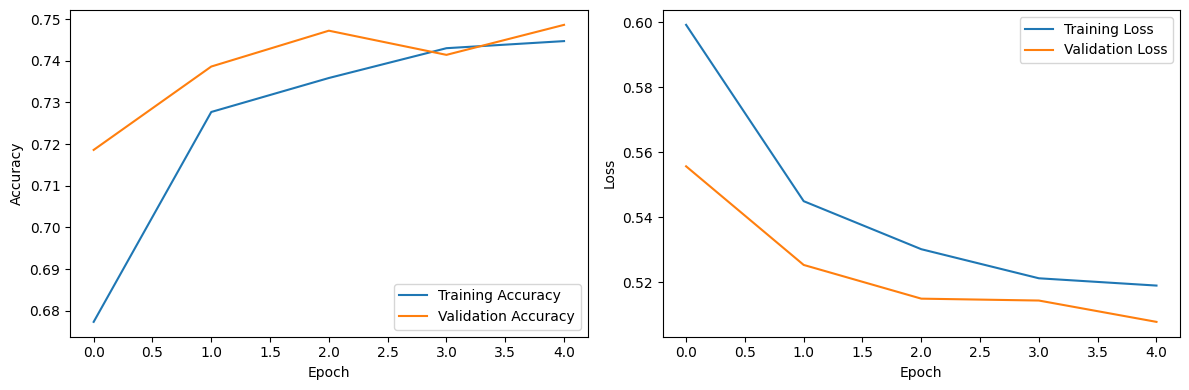

In [10]:
# Plot training metrics
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

In [11]:
# Evaluate the model on test data
loss, accuracy = classifier_model.evaluate(test_dataset)
print(f'Test accuracy: {accuracy:.3f}')

782/782 [==============================] - 345s 441ms/step - loss: 0.5059 - accuracy: 0.7521
Test accuracy: 0.752


782/782 [==============================] - 342s 437ms/step


2025-09-18 15:59:45.325106: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 1000x800 with 0 Axes>

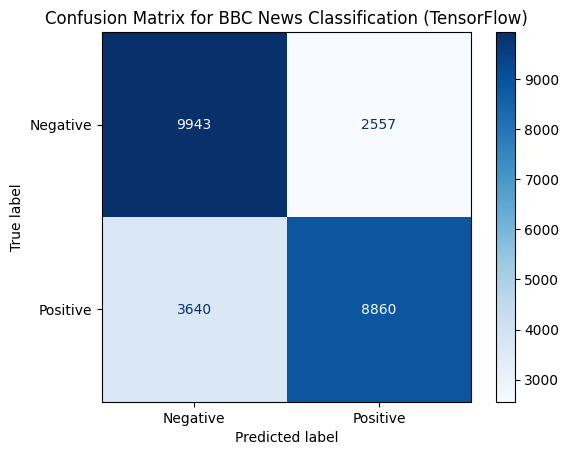


Classification Report:
              precision    recall  f1-score   support

    Negative       0.73      0.80      0.76     12500
    Positive       0.78      0.71      0.74     12500

    accuracy                           0.75     25000
   macro avg       0.75      0.75      0.75     25000
weighted avg       0.75      0.75      0.75     25000



In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


# Generate predictions for the test set
test_predictions = classifier_model.predict(test_dataset)
# Model predicts probability of class 1 via sigmoid output layer
y_pred = [1 if pred >= 0.5 else 0 for pred in test_predictions]


# Get true labels
y_true = [labels.numpy() for _, labels in test_dataset.unbatch()]


# Create and visualize the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for BBC News Classification (TensorFlow)')
plt.grid(False)
plt.show()


# Create classification report
report = classification_report(y_true, y_pred, target_names=['Negative', 'Positive'], output_dict=True)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

In [13]:
# Create a function for model inference on new articles
def predict_sentiment(text, model=classifier_model):
   """
   Predict the category of a news article using the fine-tuned model.
  
   Args:
       text (str): The text of the news article
       model: The fine-tuned TensorFlow model
      
   Returns:
       dict: Prediction results including category and confidence scores
   """
   # Make prediction
   prediction = model.predict([text])[0][0]
  
   # Get the predicted sentiment and confidence
   predicted_sentiment = "Postive" if prediction >= 0.5 else "Negative"
   confidence = float(prediction)
  
   return {
       'text': text[:100] + '...' if len(text) > 100 else text,
       'predicted_sentiment': predicted_sentiment,
       'confidence': confidence
   }
  
# Test the prediction function
sample_text = "This movie was excellent! The acting was stellar."
predictions = predict_sentiment(sample_text)
print(f"Text: {predictions['text']}")
print(f"Sentiment: {predictions['predicted_sentiment']} ({predictions['confidence']:.4f})")

1/1 [==============================] - 0s 283ms/step
Text: This movie was excellent! The acting was stellar.
Sentiment: Postive (0.6202)


In [14]:
# Save the model
model_save_path = "./bert_sentiment_model_tf"
classifier_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

INFO:tensorflow:Assets written to: ./bert_sentiment_model_tf/assets


INFO:tensorflow:Assets written to: ./bert_sentiment_model_tf/assets


Model saved to ./bert_sentiment_model_tf
